This notebook has a preprocessing step included which only needs to be run once and it can be done directly in the notebook with no need to go to the cluster. For this you should search and set `run_once = False` to True and run the associated cell once. Afterwards you can set it to False again.

# Imports

In [1]:
import os
from oggm import utils
import pandas as pd
import xarray as xr
import numpy as np
import json
import geopandas as gpd
import salem
from salem import utils as salem_utils
from salem import gis as salem_gis
from salem import wgs84
import matplotlib.pyplot as plt
from shapely.geometry import Point
import time

# Notebook or script?

If we developing or debugging the code in the notebook we use the is_notebook, if executed as a script on the cluster we ignore everything related to is_notebook.

- You can connect the script and the notebook automatically using jupytext https://jupytext.readthedocs.io/en/latest/install.html.
- Or, whenever something is changed, you must 'Save and Export Notebook As...' 'Executeable Script'.

In [2]:
# Function to detect if we're running in a Jupyter notebook
def check_if_notebook():
    try:
        shell_name = get_ipython().__class__.__name__
        if shell_name == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or JupyterLab
        elif shell_name in ['TerminalInteractiveShell', 'InteractiveShell']:
            return False  # IPython terminal or other interactive shells
        else:
            # Fallback or default behavior for unidentified environments
            return False
    except NameError:
        return False      # Not in IPython, likely standard Python interpreter

# Use this to conditionally execute tests/debugging
if check_if_notebook():
    is_notebook = True
else:
    is_notebook = False

# Open input Data

In [3]:
input_data_dir = '/home/www/pschmitt/provide/aggregate_data/data_for_aggregation/'

## RGI-IDs to provide region and batch of result files

In [4]:
# this list is already cleaned from connectivity 2, RGI19 and only common running glaciers
fp_rgi_result_batch = "rgi_ids_to_result_batch.json"
with open(os.path.join(input_data_dir, fp_rgi_result_batch), 'r') as f:
    dict_rgis_to_batch = json.load(f)

## RGI-IDs with terminus coordinates (backdrop to center coordinates)

In [5]:
df_rgi = pd.read_csv(os.path.join(input_data_dir, 'rgi_position_terminus_backdrop_centroid.csv'),
                     index_col=0)
# only keep rgi_ids which are assigned to a result file
# (excluding connectivity 2 and RGI19, in future also only commonly running glaciers)
df_rgi = df_rgi.loc[list(dict_rgis_to_batch.keys())]
df_rgi['geometry'] = df_rgi.apply(lambda row: Point(row['position_lon'], row['position_lat']), axis=1)
gdf_rgi_ids = gpd.GeoDataFrame(df_rgi, geometry='geometry', crs='EPSG:4326')

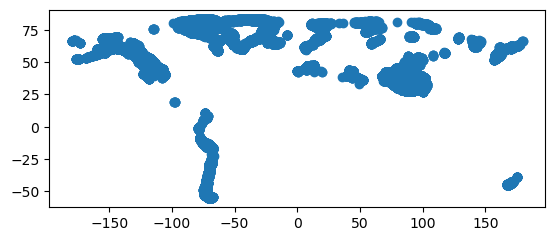

In [6]:
if is_notebook:
    gdf_rgi_ids.plot()

## Target geometry, here countries

In [7]:
countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
gdf_countries = gpd.read_file(os.path.join(input_data_dir, countries_file))
name_col_countries = 'ADM0_A3_DE'

In [72]:
if is_notebook:
    # get the index number of our test country Russia
    #test_country_index = gdf_countries[gdf_countries['NAME'] == 'Russia'].index[0]
    # China
    #test_country_index = gdf_countries[gdf_countries['NAME'] == 'China'].index[0]
    #test_country_index = gdf_countries[gdf_countries['NAME'] == 'Austria'].index[0]
    #test_country_index = 0  # this is for testing with grids with single grid point
    #test_country_index = gdf_countries[gdf_countries['NAME'] == 'Canada'].index[0]
    test_country_index = 152
    print(test_country_index)

152


# Final preprocessed structure

We start by defining a global grid with a desired resolution (e.g. 1°). Final dictionary keys are defined by the target geometry names, here country names:

  - For each country we have a list of dictionaries which can be opened with xr.Datset.from_dict():
    - list is necesarry if we cross longitude +/-180°, in this case we split the results in two grids
    - each dictonary contains the longitude and latitude of the final aggregated file structure
    - for each grid_point a list of RGI-IDs within this grid point is saved in 'rgi_ids'
    - if no RGI-IDs for a single grid point the resulting value is None
    - in 'attrs.result_batches' all files needed for this country are saved as 'Provide_region/batch_number' (e.g. 'P01/0_500')
    - in 'attrs.grid_points_with_data' the number of grid points containing data is saved, this could be useful to define the final resolution of the grid (check with dashboard developers what is computationally feasable)

## Help function as salem.grid can not handle grid with single point (because needs to know the resolution)

## Define global grid, where we cut out smaller batches for the target geometries

## Get local squared grid extracted from global grid for a single target geometry

## assing RGI-IDs to target_shapes

In [151]:
# open dict_country_to_rgi_ids from data
with open(os.path.join(input_data_dir,
                               "dict_country_to_rgi_ids.json"), "r") as f:
        dict_country_to_rgi_ids = json.load(f)

## assign RGI-IDs to grid points

/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = geoms
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `se

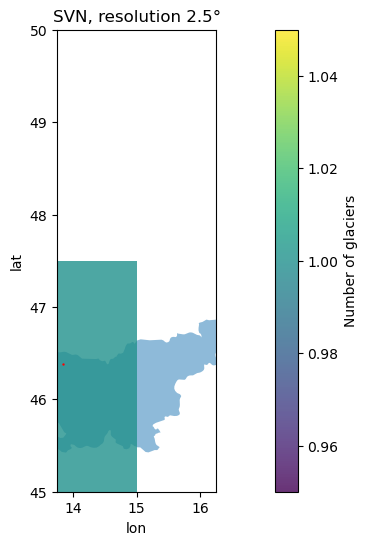

In [158]:


if is_notebook:
    country = gdf_countries.iloc[test_country_index: test_country_index + 1] #russia
    ds_local = get_squared_grid_for_shape(ds_global_grid, country)
    assign_rgi_ids_to_grid_points(ds_local, country[name_col_countries].values.item(),
                                  dict_country_to_rgi_ids, gdf_rgi_ids)

    list_length_da = plot_local_grid_with_glaciers(gdf_rgi_ids,
                                  country, ds_local,
                                  title=f'{country[name_col_countries].values[0]}, resolution '
                                  f'{ds_local[0].resolution}°', outpath=None)

## get result batches needed for the target shape

In [74]:
if is_notebook:
    country = gdf_countries.iloc[test_country_index: test_country_index + 1] #russia
    ds_local = get_squared_grid_for_shape(ds_global_grid, country)
    assign_rgi_ids_to_grid_points(ds_local, country[name_col_countries].values.item(),
                                  dict_country_to_rgi_ids, gdf_rgi_ids)
    get_result_batches_of_glaciers(ds_local, dict_rgis_to_batch)

    for i, grid_loc in enumerate(ds_local):
        print(f'{i}. grid files: {list(grid_loc.result_batches.keys())}')

/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = geoms
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `se

0. grid files: ['P06/2000_2500']
1. grid files: ['P05/1500_2000', 'P05/2000_2500', 'P05/2500_3000', 'P06/0_500', 'P06/1000_1500', 'P06/1500_2000', 'P06/2000_2500', 'P06/500_1000', 'P08/0_500', 'P08/1000_1500', 'P08/500_1000', 'P09/0_500', 'P09/1000_1500', 'P09/1500_2000', 'P09/2000_2500', 'P09/2500_3000', 'P09/500_1000']


Figure for debugging if provide regions where correctly selected
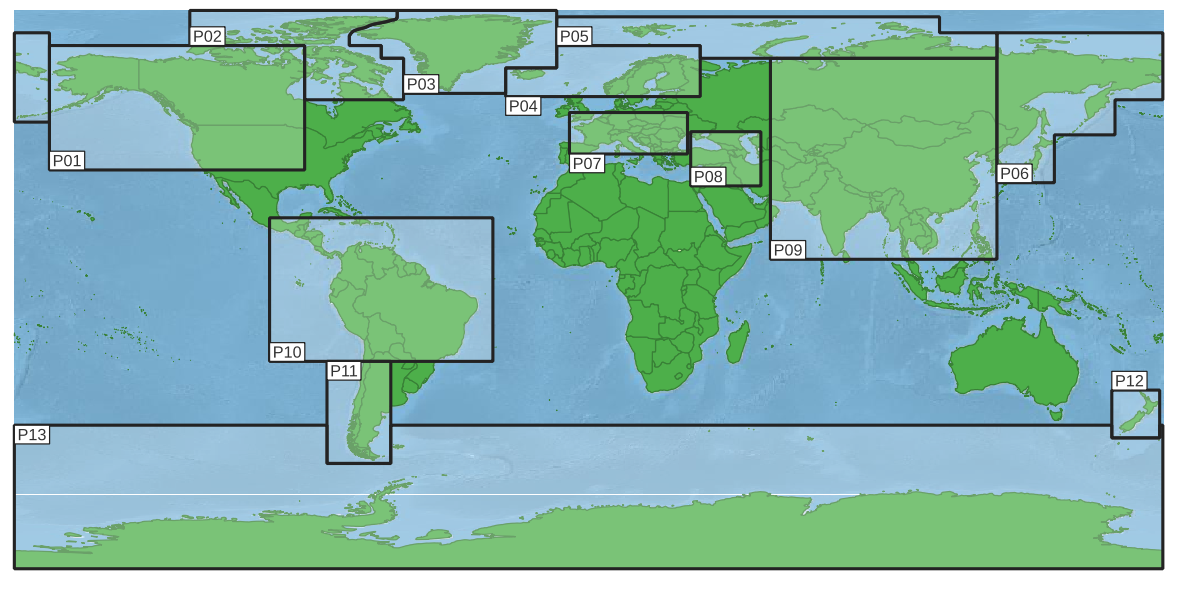

## merge multiple files into one

## save final grids as json

# Code for running on the cluster

# Coder for debugging in notebook

In [54]:
# here for debugging only
if is_notebook:
    country = gdf_countries.iloc[test_country_index: test_country_index + 1] #russia
    ds_local = get_squared_grid_for_shape(ds_global_grid, country)
    assign_rgi_ids_to_grid_points(ds_local,
                                  country[name_col_countries].values.item(),
                                  dict_country_to_rgi_ids,
                                  gdf_rgi_ids)
    get_result_batches_of_glaciers(ds_local, dict_rgis_to_batch)

    ds_local_dict = [serialize_dataset(grid).to_dict() for grid in ds_local]
    test_key = country[name_col_countries].values[0]
    final_dict = {test_key: ds_local_dict}

    with open("prepocessed_country_grids_sample_data.json", "w") as outfile: 
        json.dump(final_dict, outfile)

    # check that we can open the final data
    local_grid_reloaded = open_grid_from_dict(final_dict[test_key][0])

/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = geoms
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/salem/gis.py:1245: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `se

# Check result after running on cluster

## check for missing glaciers

Given rgi_ids: 206685, 568736.7 km2
Assigned rgi_ids: 206685, 568736.7 km2
Diff: 0, 0.0 km2


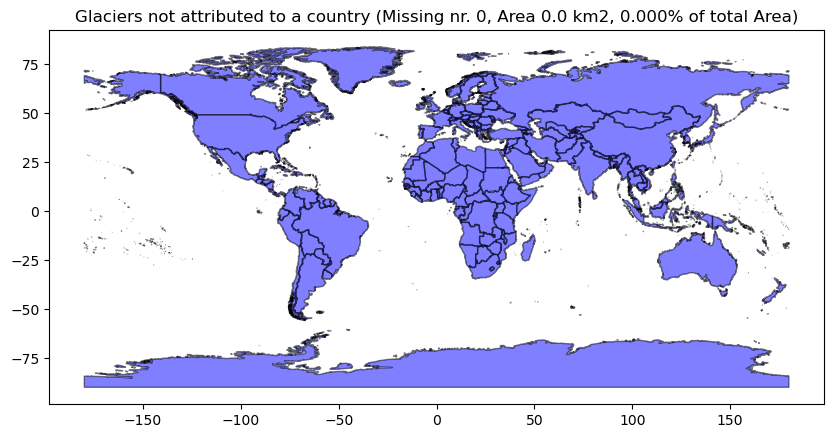

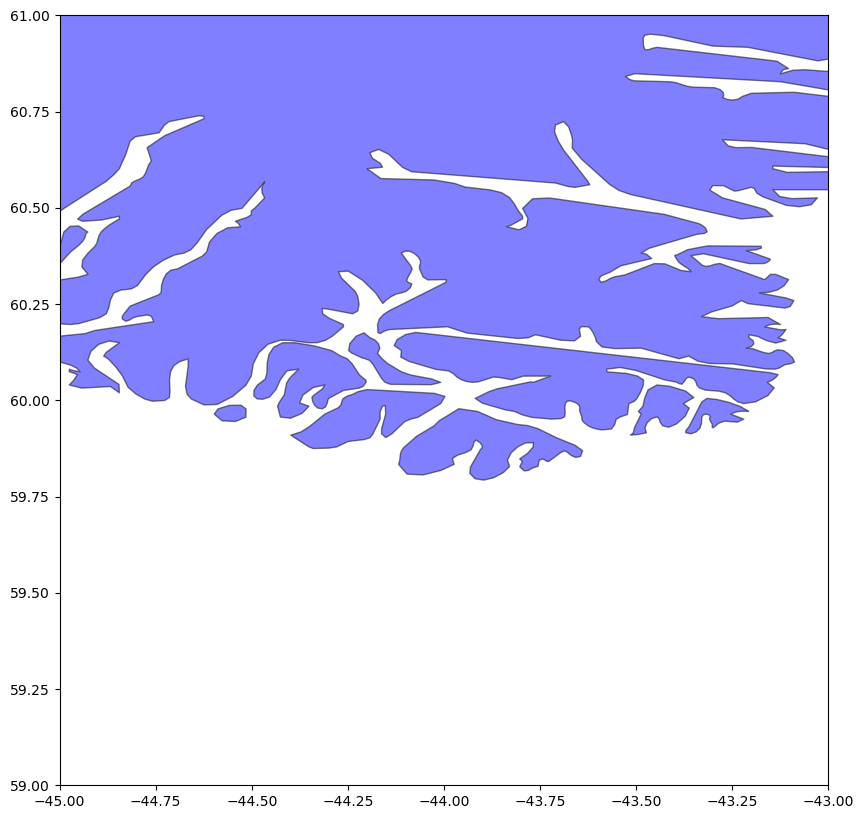

In [60]:
if is_notebook:
    final_filepath = os.path.join(input_data_dir,
                                  "preprocessed_country_grids.json")

    with open(final_filepath, 'r') as f:
        dict_final_grids = json.load(f)

    # check that all rgi_ids are assigned to a geometry
    def flatten_ds_var(ds_var):
        if isinstance(ds_var, xr.core.dataarray.DataArray):
            nested_list = ds_var.values.tolist()
        else:
            nested_list = ds_var
        # The flattened list to be returned
        flattened = []
        for item in nested_list:
            if item is None:
                continue  # Skip None values
            elif isinstance(item, list):
                # If the item is a list, recursive call
                flattened.extend(flatten_ds_var(item))
            else:
                # If the item is not a list, add it to the flattened list
                flattened.append(item)
        return flattened

    assigned_rgi_ids = []
    for key in dict_final_grids:
        try:
            ds_tmp = open_grid_from_dict(dict_final_grids[key])
            assigned_rgi_ids.extend(flatten_ds_var(ds_tmp.rgi_ids))
        except ValueError:
            print(key)

    given_rgi_ids = list(dict_rgis_to_batch.keys())

    given_area = gdf_rgi_ids.Area.sum()
    assigned_area = gdf_rgi_ids.loc[assigned_rgi_ids].Area.sum()
    assert len(given_rgi_ids) == len(np.unique(given_rgi_ids))
    assert len(assigned_rgi_ids) == len(np.unique(assigned_rgi_ids))
    print(f'Given rgi_ids: {len(given_rgi_ids)}, {given_area:.1f} km2')
    print(f'Assigned rgi_ids: {len(assigned_rgi_ids)}, {assigned_area:.1f} km2')
    print(f'Diff: {len(given_rgi_ids) - len(assigned_rgi_ids)}, {given_area - assigned_area:.1f} km2')
    
    # plot missing glaciers on map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_countries.plot(ax=ax, color='blue', edgecolor='black', linewidth=1,
                       alpha=0.5)
    gdf_missing_rgi_ids = gdf_rgi_ids[~gdf_rgi_ids.index.isin(assigned_rgi_ids)]
    if len(gdf_missing_rgi_ids) != 0:
        gdf_missing_rgi_ids.plot(ax=ax, color='red', markersize=2)
    ax.set_title(f'Glaciers not attributed to a country '
                 f'(Missing nr. {len(given_rgi_ids) - len(assigned_rgi_ids)}, '
                 f'Area {given_area - assigned_area:.1f} km2, '
                 f'{100 / given_area * (given_area - assigned_area):.3f}% of total Area)') 
    plt.show()

    # plot missing glaciers on map, zoom in to greenland
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_countries.plot(ax=ax, color='blue', edgecolor='black', linewidth=1,
                       alpha=0.5)
    gdf_missing_rgi_ids = gdf_rgi_ids[~gdf_rgi_ids.index.isin(assigned_rgi_ids)]
    if len(gdf_missing_rgi_ids) != 0:
        gdf_missing_rgi_ids.plot(ax=ax, color='red', markersize=5)
    ax.set_xlim([-45, -43])
    ax.set_ylim([59, 61])
    plt.show()

## check for uniqueness of rgi_ids in batches

In [79]:
if is_notebook:
    # check uniqueness of rgi_ids in batches
    for key in dict_final_grids:
        ds_tmp = open_grid_from_dict(dict_final_grids[key])
        raw_rgi_id_batch_list = []
        for batch in ds_tmp.result_batches:
            raw_rgi_id_batch_list.extend(ds_tmp.result_batches[batch])

        assert len(raw_rgi_id_batch_list) == len(np.unique(raw_rgi_id_batch_list)) #f'{key}'

## check that countries with glaciers and countries with no glaciers add up to total number

In [90]:
if is_notebook:
    countries_with_glaciers_filepath = os.path.join(
        input_data_dir,"preprocessed_country_grids.json"
    )
    with open(countries_with_glaciers_filepath, 'r') as f:
        countries_with_glaciers = json.load(f)

    countries_with_no_glaciers_filepath = os.path.join(
        input_data_dir, "countries_with_no_glaciers.json"
    )
    with open(countries_with_no_glaciers_filepath, 'r') as f:
        countries_with_no_glaciers = json.load(f)

    total_nr_of_countries = len(gdf_countries)
    assigned_countries = (countries_with_no_glaciers + 
                          list(countries_with_glaciers.keys()))

    assert len(np.unique(assigned_countries)) == total_nr_of_countries

    print(f'Countries with glaciers: {len(list(countries_with_glaciers.keys()))}')
    print(f'Countries without glaciers: {len(countries_with_no_glaciers)}')

Countries with glaciers: 40
Countries without glaciers: 211
